In [1]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, LayerNormalization, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

In [3]:
import sys
sys.path.append("../") 

from data_processorV4 import DataProcessorV4

processor = DataProcessorV4()
train_windows, test_windows, input_dim = processor.fit_transform("../data/merged_transaction.csv")
processor.save_processors()

d:\.HocTap\_NCKH-2025\code\fraud_detection\notebooks\..\data_processorV4.py:107: DtypeWarning: Columns (1,7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, encoding="latin-1")


✅ Created 106662 training windows and 26008 testing windows.
✅ Data processing complete (unsupervised).
✅ Đã lưu các processor cho phiên bản 'v_20251014_093614' vào ./preprocessors\v_20251014_093614
⚠️  Không thể tạo liên kết 'latest': Command '['cmd', '/c', 'mklink', '/J', './preprocessors\\latest', './preprocessors\\v_20251014_093614']' returned non-zero exit status 1.
    -> Trên Windows, hãy thử bật 'Chế độ nhà phát triển' hoặc chạy lại với quyền Admin.


'v_20251014_093614'

In [4]:
print(train_windows[:5])
print(test_windows[:5])
print("Input dimension:", input_dim)

[[[4.22508281e-04 1.37037754e-01 0.00000000e+00 ... 3.56895864e-01
   0.00000000e+00 1.00000000e+00]
  [1.58291979e-04 1.20008411e-02 1.06717693e-03 ... 3.56895864e-01
   0.00000000e+00 1.00000000e+00]
  [4.22508281e-04 2.22315732e-02 7.33684108e-04 ... 3.56895864e-01
   0.00000000e+00 1.00000000e+00]
  ...
  [1.58291979e-04 2.55011976e-01 9.99331125e-04 ... 3.56895864e-01
   0.00000000e+00 1.00000000e+00]
  [1.58291979e-04 2.68623322e-01 9.66045540e-04 ... 3.56895864e-01
   0.00000000e+00 1.00000000e+00]
  [1.82074087e-03 1.87020600e-01 9.36263765e-04 ... 3.56895864e-01
   0.00000000e+00 1.00000000e+00]]

 [[1.58291979e-04 1.20008411e-02 1.06717693e-03 ... 3.56895864e-01
   0.00000000e+00 1.00000000e+00]
  [4.22508281e-04 2.22315732e-02 7.33684108e-04 ... 3.56895864e-01
   0.00000000e+00 1.00000000e+00]
  [2.63978494e-04 1.09426655e-01 8.44848342e-04 ... 3.56895864e-01
   0.00000000e+00 1.00000000e+00]
  ...
  [1.58291979e-04 2.68623322e-01 9.66045540e-04 ... 3.56895864e-01
   0.00000

In [5]:
print(train_windows.shape[1])
print(train_windows.shape[2])

20
16


In [6]:
SEQ_LEN = train_windows.shape[1]
INPUT_DIM = train_windows.shape[2]

In [7]:
import sys
import os
sys.path.append(os.path.abspath(".."))
import importlib
import train_model_V3
importlib.reload(train_model_V3)
from train_model_V3 import LSTMAutoencoderTrainer

In [8]:
# Khởi tạo trainer
trainer = LSTMAutoencoderTrainer(seq_len=SEQ_LEN, input_dim=INPUT_DIM)

trainer.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_lstm_1 (LSTM)           │ (None, 20, 64)         │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 20, 64)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 20, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_lstm_2 (LSTM)           │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 64)             │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_vector (RepeatVector)    │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_lstm (LSTM)             │ (None, 20, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 20, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (TimeDistributed)  │ (None, 20, 16)         │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,208 (344.56 KB)

 Trainable params: 88,208 (344.56 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = trainer.fit(
    X_train=train_windows,
    X_val=test_windows,   # truyền dữ liệu validation ở đây
    epochs=70,
    batch_size=128,
    patience=10           # số epoch chờ trước khi dừng sớm
)

Epoch 1/70
834/834 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - loss: 0.1621 - val_loss: 0.0646
Epoch 2/70
834/834 ━━━━━━━━━━━━━━━━━━━━ 25s 29ms/step - loss: 0.0655 - val_loss: 0.0445
Epoch 3/70
834/834 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - loss: 0.0544 - val_loss: 0.0426
Epoch 4/70
834/834 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - loss: 0.0502 - val_loss: 0.0348
Epoch 5/70
834/834 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - loss: 0.0470 - val_loss: 0.0347
Epoch 6/70
834/834 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - loss: 0.0449 - val_loss: 0.0314
Epoch 7/70
834/834 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - loss: 0.0432 - val_loss: 0.0310
Epoch 8/70
834/834 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - loss: 0.0419 - val_loss: 0.0324
Epoch 9/70
834/834 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - loss: 0.0410 - val_loss: 0.0303
Epoch 10/70
834/834 ━━━━━━━━━━━━━━━━━━━━ 30s 36ms/step - loss: 0.0400 - val_loss: 0.0308
Epoch 11/70
834/834 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - loss: 0.0396 - val_loss: 0.0284
Epoch 12/70
834/834 ━━━━━━━━━━

In [10]:
# lưu ngưỡng 95%
trainer.calculate_and_save_threshold(train_windows, percentile=95, path="models/lstm_threshold_V4_95.pkl")

3334/3334 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step
✅ Threshold saved to models/lstm_threshold_V4_95.pkl. Value: 0.0235


In [11]:
# Lưu ngưỡng 98%
trainer.calculate_and_save_threshold(train_windows, percentile=98, path="models/lstm_threshold_V4_98.pkl")

3334/3334 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step
✅ Threshold saved to models/lstm_threshold_V4_98.pkl. Value: 0.0323


In [12]:
# Lưu ngưỡng 99%
trainer.calculate_and_save_threshold(train_windows, percentile=99, path="models/lstm_threshold_V4_99.pkl")

3334/3334 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step
✅ Threshold saved to models/lstm_threshold_V4_99.pkl. Value: 0.0403


In [13]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Flatten về 2D: (n_samples, window_size * n_features)
y_true = train_windows.reshape(len(train_windows), -1)

# baseline = luôn dự đoán mean của train labels
mean_prediction = np.mean(y_true, axis=0)

# tạo y_pred có cùng shape
y_pred = np.tile(mean_prediction, (len(y_true), 1))

# tính MSE
baseline_mse = mean_squared_error(y_true, y_pred)
print("Baseline MSE:", baseline_mse)


Baseline MSE: 0.09833681583404541


In [14]:
trainer.save_model("models/autoencoderV4_pro_model")

✅ Model saved to models/autoencoderV4_pro_model.keras


In [15]:
reconstructions = trainer.model.predict(train_windows)
mse = np.mean(np.power(train_windows - reconstructions, 2), axis=(1, 2))
threshold = trainer.load_threshold("models/lstm_threshold_V4_tmp_pro.pkl")
threshold = trainer.threshold

3334/3334 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step
✅ Threshold loaded from models/lstm_threshold_V4_tmp_pro.pkl. Value: 0.0263


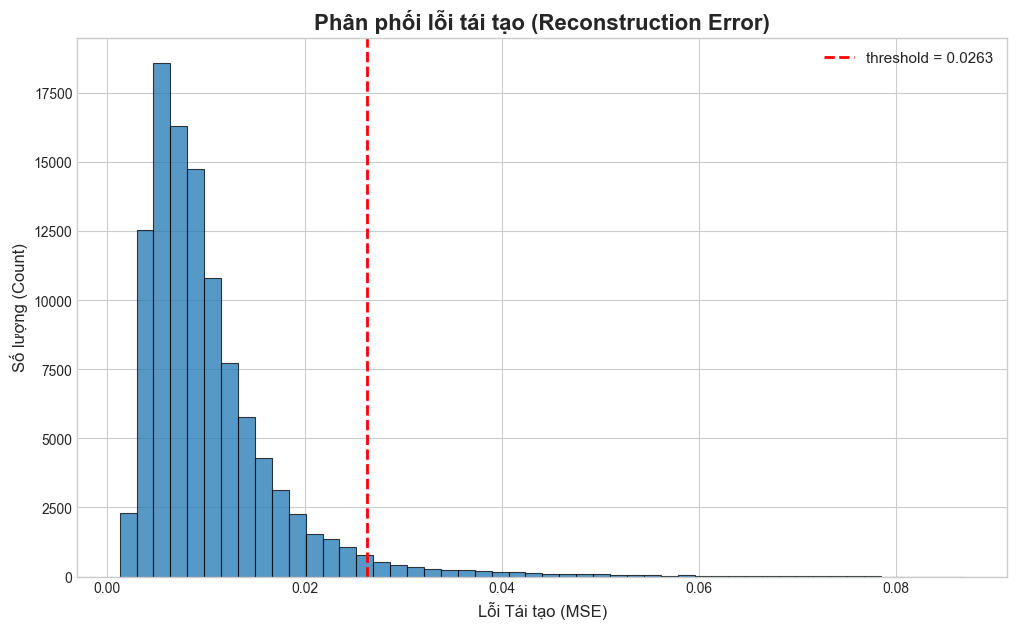

In [16]:
import matplotlib.pyplot as plt

# BƯỚC 1: Chọn một style để biểu đồ đẹp hơn ngay lập tức
plt.style.use('seaborn-v0_8-whitegrid')

# BƯỚC 2: Tạo một figure với kích thước lớn hơn để dễ nhìn
plt.figure(figsize=(12, 7))

# BƯỚC 3: Vẽ histogram với các tùy chỉnh bổ sung
plt.hist(
    mse,
    bins=50,
    alpha=0.75,         # Làm cho các thanh hơi trong suốt
    edgecolor='black',  # Thêm đường viền đen cho mỗi thanh để rõ ràng hơn
    linewidth=0.8
)

# BƯỚC 4: Làm nổi bật tiêu đề và các nhãn
plt.title("Phân phối lỗi tái tạo (Reconstruction Error)", fontsize=16, fontweight='bold')
plt.xlabel("Lỗi Tái tạo (MSE)", fontsize=12)
plt.ylabel("Số lượng (Count)", fontsize=12)

# BƯỚC 5: Tùy chỉnh đường ngưỡng (threshold) để nổi bật hơn
plt.axvline(
    threshold,
    color='r',
    linestyle='--',
    linewidth=2, # Làm cho đường dày hơn
    label=f"threshold = {threshold:.4f}"
)

# Hiển thị chú thích (legend) ở vị trí tốt nhất
plt.legend(fontsize=11)

# Hiển thị biểu đồ
plt.show()